In [1]:
import sys
sys.path.append('/home/ruyogagp/medical_interpretability')
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from cga import cga
import pandas as pd
import neptune.new as neptune
import wandb
import pytorch_lightning as pl
import torch.nn as nn
import torch
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from captum.attr import *
from captum.metrics import *
from captum._utils.models.linear_model import SkLearnLinearRegression
from source.wrappers import ForwardWrapper
import os
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import torch.distributions as dist
import matplotlib.gridspec as gridspec
import wandb
import pytorch_lightning as pl
from source.tasks import DeepSurv

In [17]:
import shap_fork as shap_fork

## Prep Simpsons Dataset

In [2]:
df = pd.read_csv('/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/simpsons_revised_train.csv')
df.loc[:, 'x'] = df['feature0']
df.loc[:, 'y'] = df['feature1']
del df['feature0']
del df['feature1']

In [46]:
df['y'].min()

-3.056437596336473

In [3]:
api = wandb.Api()
experiment_id = 'simpsons_revised'
runs =  api.runs('cardiors/interpretability',
                 filters={"$and": [{'tags': f'{experiment_id}'}, {'tags': 'resample_multiplicities'}, {'state': 'finished'}]})

# Select the first run from the runs list
run = runs[1]
model_path = run.config['checkpoint_path']

In [4]:
def create_steps(size=100):
    return np.meshgrid(np.linspace(0, 1, size), np.linspace(0, 1, size))

def create_steps_simpson(size=100):
    return np.meshgrid(np.linspace(-7, 7, size), np.linspace(-7, 7, size))

def get_model_output(model, steps=100):
    x1, x2 = create_steps_simpson(steps)
    x1_flat, x2_flat = x1.reshape(len(x1)**2), x2.reshape(len(x2)**2)

    outs = np.empty([len(x1.reshape(len(x1)**2))])

    for c, data in enumerate(zip(x1_flat, x2_flat)):
        with torch.no_grad():
            xi1,xi2 = data
            x = torch.tensor([xi1,xi2], requires_grad=False)#.to(dev)

            # Workarounds..
            x = x.type(torch.FloatTensor)
            model = model.type(torch.FloatTensor)
            #             x = x.to(dev)
            #             x=x.cpu()
            #             model=model.cpu()
            #             model = model.type(torch.FloatTensor)
            x = x.unsqueeze(0)
            out = model.net(x)#.double()
            outs[c] = out
    return outs, x1, x2

def plot_contour(outs, x1, x2, title=''):
    if outs.ndim == 1:
        plt.figure(figsize=[6, 6])
        z = outs.reshape(int(np.sqrt(outs.shape)), int(np.sqrt(outs.shape)))
        #         plt.contourf(x1, x2, z, cmap='seismic')
        plt.scatter(x1, x2, c=z, vmax=abs(z).max(), vmin=-abs(z).max(), cmap='seismic')
        plt.title('Output Visualization ' + title)
        plt.grid(False)
        plt.colorbar()
    else:
        plt.figure(figsize=[12, 6])
        for dim in range(outs.ndim):
            z = outs[dim].reshape(int(np.sqrt(outs[dim].shape)), int(np.sqrt(outs[dim].shape)))
            plt.subplot(int(np.floor(dim/3))+1, 2, dim+1)
            #             plt.contourf(x1, x2, z, cmap='seismic')
            plt.scatter(x1, x2, c=z, vmax=abs(z).max(), vmin=-abs(z).max(), cmap='seismic')
            plt.title('Dimension ' + str(dim+1))
            plt.grid(False)
            plt.colorbar()
    plt.show()

def get_attribution_output(method, steps=100, name=None):
    x1, x2 = create_steps_simpson(steps)
    x1_flat, x2_flat = x1.reshape(len(x1)**2), x2.reshape(len(x2)**2)

    # first outs dim is number of dims of attr
    outs = np.empty([2, len(x1.reshape(len(x1)**2))])

    for c, data in enumerate(zip(x1_flat, x2_flat)):
        with torch.no_grad():
            xi1,xi2 = data
            # Create sample of this iteration
            x = torch.tensor([[xi1,xi2]], requires_grad=True)#.to(dev)
            ## Workarounds
            x = x.type(torch.FloatTensor)
            # Attribute!
            if name == 'Occ':
                baseline = 0.5
                attr = method.attribute(x, sliding_window_shapes=(1,), baselines=torch.tensor([baseline, baseline])[None].to(dev))
            elif name == 'IG':
                baseline = .5
                attr = method.attribute(x, baselines=baseline)
            else:
                attr = method.attribute(x)

            for dim in range(len(attr[0])): # take first and only batch -> attr[0]
                outs[dim, c] = attr[0, dim]
    return outs, x1, x2

In [5]:
x1, x2 = create_steps_simpson(100)
x1_flat, x2_flat = x1.reshape(len(x1)**2), x2.reshape(len(x2)**2)

outs = np.empty([len(x1.reshape(len(x1)**2))])

<ipython-input-4-f37ad7e141bf>:38: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


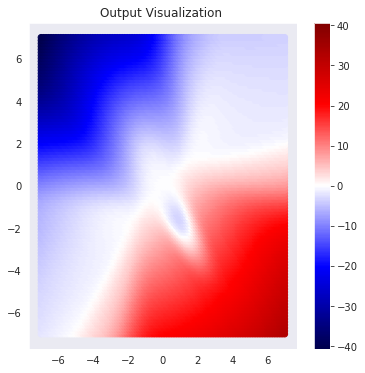

In [6]:
steps = 100
trained_model = DeepSurv.load_from_checkpoint(model_path)
model = trained_model.eval()
plot_outputs, x1, x2 = get_model_output(model, steps=steps)
x1_flat, x2_flat = x1.reshape(len(x1)**2), x2.reshape(len(x2)**2)
plot_contour(plot_outputs, x1, x2)

In [7]:
# Get attribution results from Captum
methods = {
    'Saliency': Saliency(model),
    'Smoothgrad': NoiseTunnel(Saliency(model)),
    'IG': IntegratedGradients(model),
    'IxG': InputXGradient(model),
    'GuidedBackprop': GuidedBackprop(model),
    #'GuidedGradCAM': GuidedGradCam(model, model.fc1),
    #'DeepLift': DeepLift(model),  TODO: fix error; try skipping relu layer
    'Deconvolution': Deconvolution(model),
    'FeatureAblation': FeatureAblation(model),
    'Occlusion': Occlusion(model),
    #'FeaturePermutation': FeaturePermutation(model),
    #'ShapleyValueSampling': ShapleyValueSampling(model)
}

## Forward wrapper

In [8]:
class ForwardWrapper(nn.Module):
    def __init__(self, trained_model, method, **kwargs):
        """
        :param trained_model: trained model to compute attribution for
        :param attribution_endpoint: endpoint to attribute to
        :param attribution_timepoint: timepoint to attribute to (currently not used for DeepSurv)
        :param method: ['KernelExplainer','DeepExplainer']
        """
        super().__init__()
        self.trained_model = trained_model
        self.method = method
        self.bhs = trained_model.bhs

    def forward(self, inputs, t=None):
        inputs = inputs if self.method == 'DeepExplainer' else torch.Tensor(inputs)
        return self.trained_model(inputs)[0]

<ipython-input-4-f37ad7e141bf>:38: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


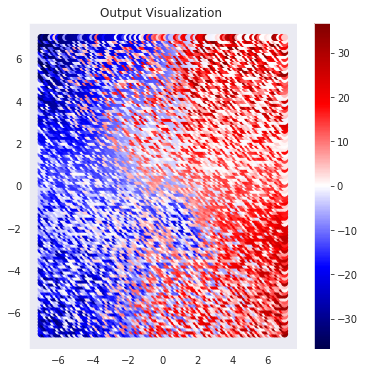

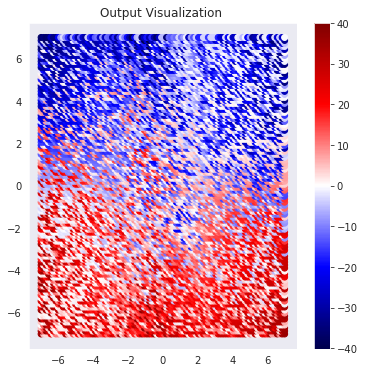

In [9]:
stack = torch.stack([torch.Tensor(x1_flat), torch.Tensor(x2_flat)], dim=1)
wrapped_model = ForwardWrapper(trained_model, method='FeaturePermutation')
fp = FeaturePermutation(wrapped_model)
explanation = fp.attribute(stack, additional_forward_args=10.0);
for i in range(2):
    exp = explanation[:, i].detach().numpy()
    plot_contour(exp, x1, x2);

/data/analysis/ag-reils/ruyogagp/envs/greg/lib/python3.9/site-packages/captum/_utils/gradient.py:56: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
<ipython-input-4-f37ad7e141bf>:38: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


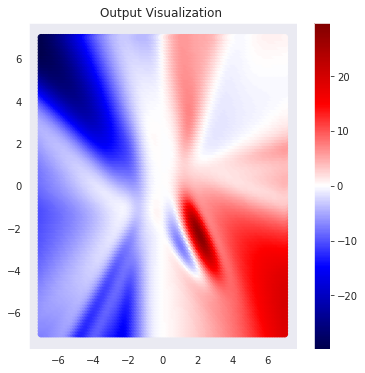

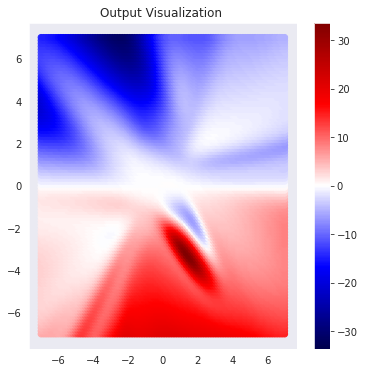

In [10]:
stack = torch.stack([torch.Tensor(x1_flat), torch.Tensor(x2_flat)], dim=1)
wrapped_model = ForwardWrapper(trained_model, method='FeaturePermutation')
fp = InputXGradient(wrapped_model)
explanation = fp.attribute(stack, additional_forward_args=10.0);
for i in range(2):
    exp = explanation[:, i].detach().numpy()
    plot_contour(exp, x1, x2);

<ipython-input-4-f37ad7e141bf>:38: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


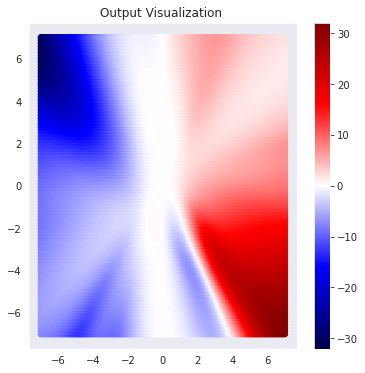

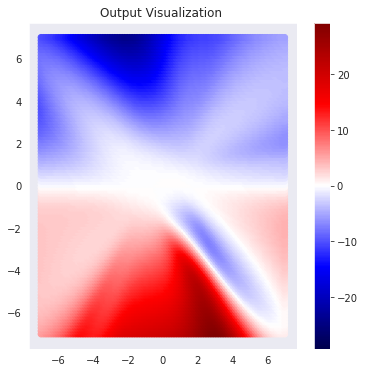

In [11]:
stack = torch.stack([torch.Tensor(x1_flat), torch.Tensor(x2_flat)], dim=1)
wrapped_model = ForwardWrapper(trained_model, method='FeaturePermutation')
fp = IntegratedGradients(wrapped_model)
explanation = fp.attribute(stack)
for i in range(2):
    exp = explanation[:, i].detach().numpy()
    plot_contour(exp, x1, x2);

/data/analysis/ag-reils/ruyogagp/envs/greg/lib/python3.9/site-packages/captum/attr/_core/lime.py:1101: UserWarning: You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.
  warnings.warn(
<ipython-input-4-f37ad7e141bf>:38: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


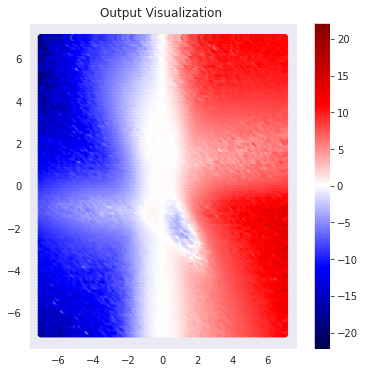

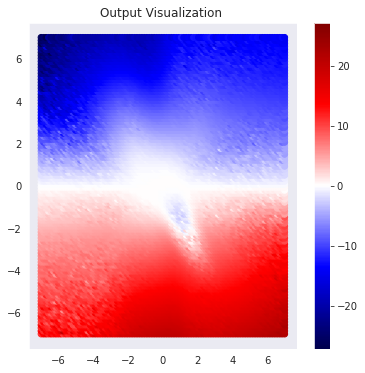

In [12]:
stack = torch.stack([torch.Tensor(x1_flat), torch.Tensor(x2_flat)], dim=1)
wrapped_model = ForwardWrapper(trained_model, method='FeaturePermutation')
fp = Lime(wrapped_model)
explanation = fp.attribute(stack)
for i in range(2):
    exp = explanation[:, i].detach().numpy()
    plot_contour(exp, x1, x2);

In [13]:
stack = torch.stack([torch.Tensor(x1_flat), torch.Tensor(x2_flat)], dim=1)

In [16]:
wrapped_task = ForwardWrapper(trained_model, method='KernelExplainer')
baseline = torch.zeros(1, stack[0].shape[1])
expl

In [20]:
method = InputXGradient(model)
name = 'ixg'
x1, x2 = create_steps_simpson(steps)
x1_flat, x2_flat = x1.reshape(len(x1)**2), x2.reshape(len(x2)**2)

# first outs dim is number of dims of attr
outs = np.empty([2, len(x1.reshape(len(x1)**2))])

for c, data in enumerate(zip(x1_flat, x2_flat)):
    with torch.no_grad():
        xi1,xi2 = data
        # Create sample of this iteration
        x = torch.tensor([[xi1,xi2]], requires_grad=True)#.to(dev)
        ## Workarounds
        x = x.type(torch.FloatTensor)
        # Attribute!
        if name == 'Occ':
            baseline = 0.5
            attr = method.attribute(x, sliding_window_shapes=(1,), baselines=torch.tensor([baseline, baseline])[None].to(dev))
        elif name == 'IG':
            baseline = .5
            attr = method.attribute(x, baselines=baseline)
        else:
            attr = method.attribute(x)

/data/analysis/ag-reils/ruyogagp/envs/greg/lib/python3.9/site-packages/captum/_utils/gradient.py:56: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


TypeError: unbind(): argument 'input' (position 1) must be Tensor, not tuple

## Check attribution outputs

In [29]:
import pandas as pd

In [6]:
experiment_name = 'simpsons_revised'
f0_points = pd.read_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/{experiment_name}_attribute_feature0.csv')
f1_points = pd.read_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/{experiment_name}_attribute_feature1.csv')

In [30]:
pd.read_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/{experiment_name}/f0_points.csv', index_col=0)

,feature0_orig,feature1_orig,time,event,InputxGradient,FeaturePermutation,IntegratedGradients,DeepExplainer,KernelExplainer,Lime
0,1.125175,1.438266,0.000000,0.0,-0.595414,0.268321,-0.144696,-0.163245,-0.114343,-0.076270
1,1.471001,0.469322,0.395653,1.0,0.293778,0.840607,0.230498,0.163813,0.326745,0.379858
2,2.276231,4.264510,0.000000,0.0,-0.140441,0.204597,-0.046769,-0.031574,-0.082332,-0.061523
3,2.599138,5.102565,4.213791,1.0,-0.268217,-0.180526,-0.155417,-0.080381,-0.185617,-0.216085
4,0.749869,-0.716240,0.357405,1.0,-1.440281,2.753581,-0.092817,-0.594368,-0.359664,-0.355625
...,...,...,...,...,...,...,...,...,...,...
4995,4.429013,3.173210,0.402929,1.0,2.485765,2.431034,2.504922,2.934886,2.840557,2.702673
4996,3.340554,2.733156,0.000000,0.0,2.180832,0.674710,0.784375,0.872188,0.835432,0.760744
4997,3.835822,4.547573,0.000000,0.0,2.941351,1.229149,1.192282,1.620946,1.418925,1.082118
4998,0.891179,1.282869,1.039952,1.0,-1.149066,-2.640828,-0.339371,-0.377389,-0.282121,-0.148701


In [45]:
df0 = pd.read_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/{experiment_name}/f0_points.csv', index_col=0)
df0

,feature0_orig,feature1_orig,time,event,InputxGradient,FeaturePermutation,IntegratedGradients,DeepExplainer,KernelExplainer,Lime,attribution_method
0,1.125175,1.438266,0.000000,0.0,-0.595414,0.268321,-0.144696,-0.163245,-0.114343,-0.076270,Lime
1,1.471001,0.469322,0.395653,1.0,0.293778,0.840607,0.230498,0.163813,0.326745,0.379858,Lime
2,2.276231,4.264510,0.000000,0.0,-0.140441,0.204597,-0.046769,-0.031574,-0.082332,-0.061523,Lime
3,2.599138,5.102565,4.213791,1.0,-0.268217,-0.180526,-0.155417,-0.080381,-0.185617,-0.216085,Lime
4,0.749869,-0.716240,0.357405,1.0,-1.440281,2.753581,-0.092817,-0.594368,-0.359664,-0.355625,Lime
...,...,...,...,...,...,...,...,...,...,...,...
4995,4.429013,3.173210,0.402929,1.0,2.485765,2.431034,2.504922,2.934886,2.840557,2.702673,Lime
4996,3.340554,2.733156,0.000000,0.0,2.180832,0.674710,0.784375,0.872188,0.835432,0.760744,Lime
4997,3.835822,4.547573,0.000000,0.0,2.941351,1.229149,1.192282,1.620946,1.418925,1.082118,Lime
4998,0.891179,1.282869,1.039952,1.0,-1.149066,-2.640828,-0.339371,-0.377389,-0.282121,-0.148701,Lime


In [47]:
import seaborn as sns

In [68]:
fa_method = 'InputxGradient'
def plot_attr_output(fa_method):
    experiment_name = 'simpsons_revised'
    f0_points = pd.read_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/{experiment_name}/f0_points.csv', index_col=0)
    f1_points = pd.read_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/{experiment_name}/f1_points.csv', index_col=0)
    seed = 112
    working_dir = f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/{experiment_name}'
    feature1 = pd.read_csv(f'{working_dir}/{fa_method}_feature1_{seed}.csv', header=None)
    feature0 = pd.read_csv(f'{working_dir}/{fa_method}_feature0_{seed}.csv', header=None)
    f0_points.loc[:, fa_method] = feature0[0]
    f0_points.loc[:, 'attribution_method'] = fa_method
    f1_points.loc[:, fa_method] = feature1[1]
    f1_points.loc[:, 'attribution_method'] = fa_method
    f0_points.to_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/{experiment_name}/f0_points_{fa_method}.csv')
    f1_points.to_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/{experiment_name}/f1_points_{fa_method}.csv')

    color = feature0[0]
    f0_points.plot.scatter('feature0_orig', 'feature1_orig', c=color, cmap='seismic',
                           vmax=abs(color).max(), vmin=-abs(color).max())
    color = feature1[1]
    f1_points.plot.scatter('feature0_orig', 'feature1_orig', c=color, cmap='seismic',
                           vmax=abs(color).max(), vmin=-abs(color).max())


In [52]:
import matplotlib.pyplot as plt

In [78]:
df0 = pd.read_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/{experiment_name}/f0_points_{fa_method}.csv', index_col=0)

In [84]:
df0

,feature0_orig,feature1_orig,time,event,InputxGradient,FeaturePermutation,IntegratedGradients,DeepExplainer,KernelExplainer,Lime,attribution_method
0,1.125175,1.438266,0.000000,0.0,-0.595414,0.268321,-0.144696,-0.163245,-0.114343,-0.076270,InputxGradient
1,1.471001,0.469322,0.395653,1.0,0.293778,0.840607,0.230498,0.163813,0.326745,0.379858,InputxGradient
2,2.276231,4.264510,0.000000,0.0,-0.140441,0.204597,-0.046769,-0.031574,-0.082332,-0.061523,InputxGradient
3,2.599138,5.102565,4.213791,1.0,-0.268217,-0.180526,-0.155417,-0.080381,-0.185617,-0.216085,InputxGradient
4,0.749869,-0.716240,0.357405,1.0,-1.440281,2.753581,-0.092817,-0.594368,-0.359664,-0.355625,InputxGradient
...,...,...,...,...,...,...,...,...,...,...,...
4995,4.429013,3.173210,0.402929,1.0,2.485765,2.431034,2.504922,2.934886,2.840557,2.702673,InputxGradient
4996,3.340554,2.733156,0.000000,0.0,2.180832,0.674710,0.784375,0.872188,0.835432,0.760744,InputxGradient
4997,3.835822,4.547573,0.000000,0.0,2.941351,1.229149,1.192282,1.620946,1.418925,1.082118,InputxGradient
4998,0.891179,1.282869,1.039952,1.0,-1.149066,-2.640828,-0.339371,-0.377389,-0.282121,-0.148701,InputxGradient


Text(0, 0.5, 'Feature 1')

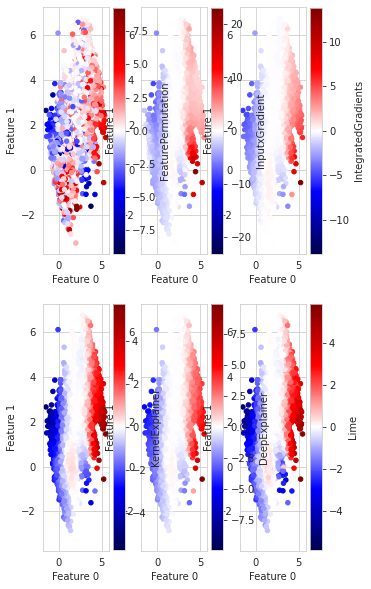

In [99]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(35, 60))
color = 'FeaturePermutation'
ax = df0.plot.scatter('feature0_orig', 'feature1_orig', c=color,
                       cmap='seismic',
                       vmax=abs(df0[color]).max(),
                       vmin=-abs(df0[color]).max(),
                       ax=axes[0, 0],
                       figsize=(5,10))
ax.set_xlabel("Feature 0")
ax.set_ylabel("Feature 1")

color = 'InputxGradient'
ax = df0.plot.scatter('feature0_orig', 'feature1_orig', c=color,
                       cmap='seismic',
                       vmax=abs(df0[color]).max(),
                       vmin=-abs(df0[color]).max(),
                       ax=axes[0, 1],
                       figsize=(5,10))
ax.set_xlabel("Feature 0")
ax.set_ylabel("Feature 1")

color = 'IntegratedGradients'
ax = df0.plot.scatter('feature0_orig', 'feature1_orig', c=color,
                 cmap='seismic',
                 vmax=abs(df0[color]).max(),
                 vmin=-abs(df0[color]).max(),
                 ax=axes[0, 2],
                 figsize=(5,10))
ax.set_xlabel("Feature 0")
ax.set_ylabel("Feature 1")

color = 'KernelExplainer'
ax = df0.plot.scatter('feature0_orig', 'feature1_orig', c=color,
                 cmap='seismic',
                 vmax=abs(df0[color]).max(),
                 vmin=-abs(df0[color]).max(),
                 ax=axes[1, 0],
                 figsize=(5,10))
ax.set_xlabel("Feature 0")
ax.set_ylabel("Feature 1")

color = 'DeepExplainer'
ax = df0.plot.scatter('feature0_orig', 'feature1_orig', c=color,
                 cmap='seismic',
                 vmax=abs(df0[color]).max(),
                 vmin=-abs(df0[color]).max(),
                 ax=axes[1, 1],
                 figsize=(5,10))
ax.set_xlabel("Feature 0")
ax.set_ylabel("Feature 1")

color = 'Lime'
ax = df0.plot.scatter('feature0_orig', 'feature1_orig', c=color,
                 cmap='seismic',
                 vmax=abs(df0[color]).max(),
                 vmin=-abs(df0[color]).max(),
                 ax=axes[1, 2],
                 figsize=(5,10))
ax.set_xlabel("Feature 0")
ax.set_ylabel("Feature 1")


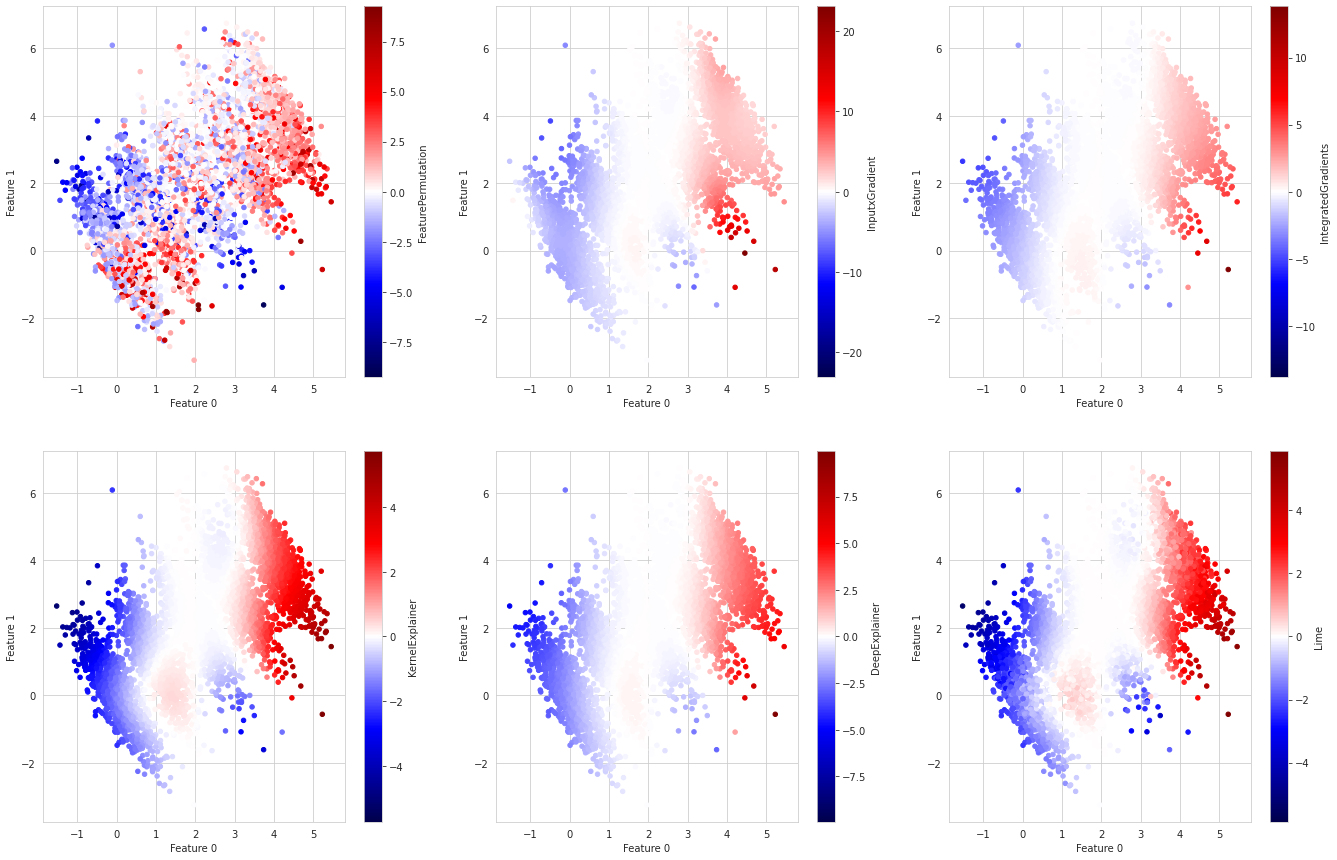

In [100]:
fig.set_figheight(15)
fig.set_figwidth(23)
fig

In [65]:
f0_points

,feature0_orig,feature1_orig,time,event,InputxGradient,FeaturePermutation
0,1.125175,1.438266,0.000000,0.0,-0.142934,0.268321
1,1.471001,0.469322,0.395653,1.0,3.105313,0.840607
2,2.276231,4.264510,0.000000,0.0,3.160533,0.204597
3,2.599138,5.102565,4.213791,1.0,-0.250732,-0.180526
4,0.749869,-0.716240,0.357405,1.0,-0.502786,2.753581
...,...,...,...,...,...,...
4995,4.429013,3.173210,0.402929,1.0,-0.714042,2.431034
4996,3.340554,2.733156,0.000000,0.0,-0.004437,0.674710
4997,3.835822,4.547573,0.000000,0.0,0.032132,1.229149
4998,0.891179,1.282869,1.039952,1.0,3.113173,-2.640828


In [123]:
EVALUATION_DIR = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/evaluation'
experiment_id = 'simpsons_revised'
idx = 0
seed = 112
change_slope = pd.read_csv(f'{EVALUATION_DIR}/{experiment_id}/change_slope/feature{idx}_{seed}.csv')

<AxesSubplot:xlabel='feature0_orig', ylabel='feature1_orig'>

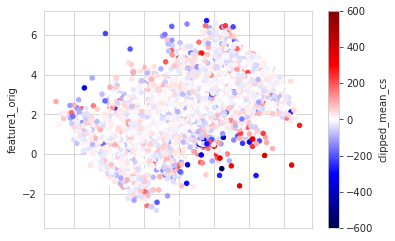

In [124]:
color = 'clipped_mean_cs'
change_slope.plot.scatter('feature0_orig', 'feature1_orig', c=color, cmap='seismic',
                          vmax=abs(change_slope[color]).max(),
                          vmin=-abs(change_slope[color]).max(),)

<AxesSubplot:xlabel='feature0_orig', ylabel='feature1_orig'>

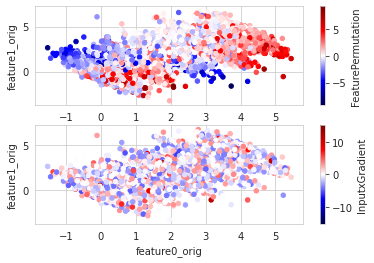

In [66]:
fig, axes = plt.subplots(nrows=2, ncols=1)
color = 'FeaturePermutation'
f0_points.plot.scatter('feature0_orig', 'feature1_orig', c=color,
                       cmap='seismic',
                       vmax=abs(f0_points[color]).max(),
                       vmin=-abs(f0_points[color]).max(),
                       ax=axes[0])

color = 'InputxGradient'
f0_points.plot.scatter('feature0_orig', 'feature1_orig', c=color,
                       cmap='seismic',
                       vmax=abs(f0_points[color]).max(),
                       vmin=-abs(f0_points[color]).max(),
                       ax=axes[1])

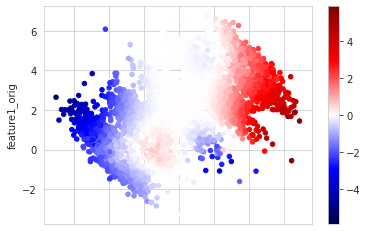

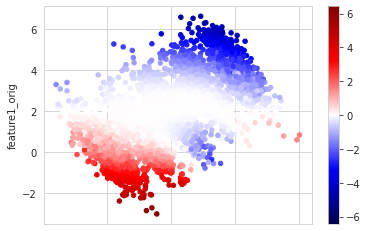

In [70]:
plot_attr_output('Lime')

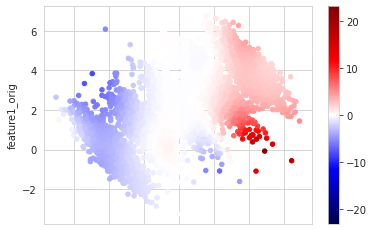

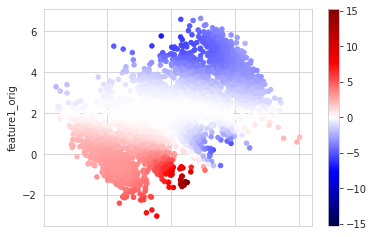

In [71]:
plot_attr_output('InputxGradient')

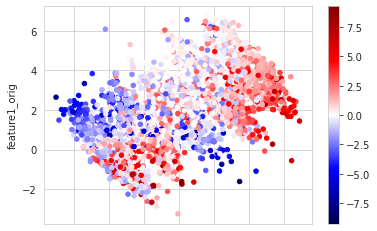

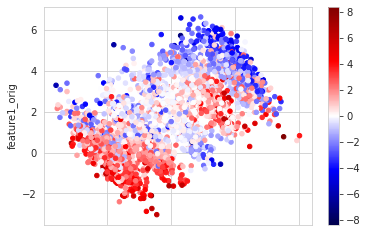

In [72]:
plot_attr_output('FeaturePermutation')

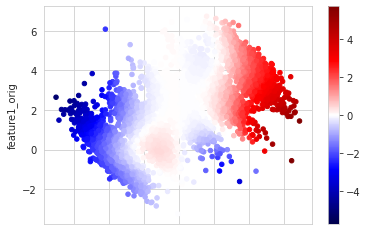

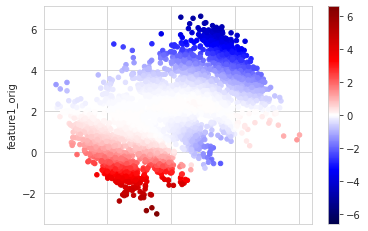

In [73]:
plot_attr_output('KernelExplainer')

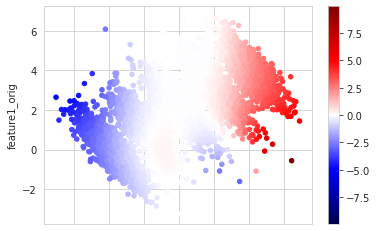

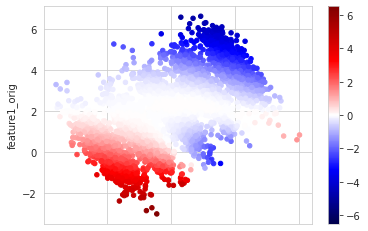

In [74]:
plot_attr_output('DeepExplainer')

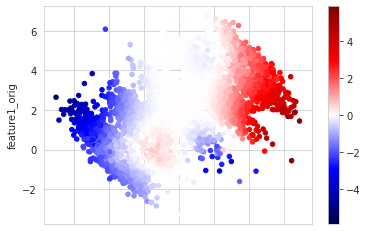

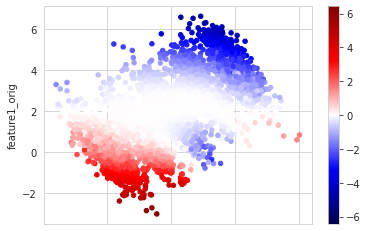

In [75]:
plot_attr_output('Lime')

<AxesSubplot:xlabel='feature0_orig', ylabel='feature1_orig'>

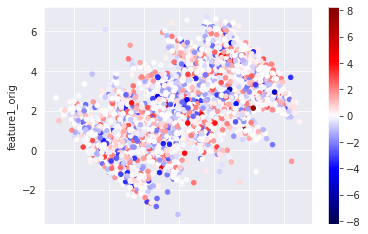

In [58]:
color = feature1[0]
f0_points.plot.scatter('feature0_orig', 'feature1_orig', c=color, cmap='seismic',
                       vmax=abs(color).max(), vmin=-abs(color).max())

In [31]:
pd.read_csv(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/resample_multiplicities/{experiment_name}/f0_points.csv', index_col=0)

,feature0_orig,feature1_orig,time,event,InputxGradient,FeaturePermutation,IntegratedGradients,DeepExplainer,KernelExplainer,Lime
0,1.125175,1.438266,0.000000,0.0,-0.595414,0.268321,-0.144696,-0.163245,-0.114343,-0.076270
1,1.471001,0.469322,0.395653,1.0,0.293778,0.840607,0.230498,0.163813,0.326745,0.379858
2,2.276231,4.264510,0.000000,0.0,-0.140441,0.204597,-0.046769,-0.031574,-0.082332,-0.061523
3,2.599138,5.102565,4.213791,1.0,-0.268217,-0.180526,-0.155417,-0.080381,-0.185617,-0.216085
4,0.749869,-0.716240,0.357405,1.0,-1.440281,2.753581,-0.092817,-0.594368,-0.359664,-0.355625
...,...,...,...,...,...,...,...,...,...,...
4995,4.429013,3.173210,0.402929,1.0,2.485765,2.431034,2.504922,2.934886,2.840557,2.702673
4996,3.340554,2.733156,0.000000,0.0,2.180832,0.674710,0.784375,0.872188,0.835432,0.760744
4997,3.835822,4.547573,0.000000,0.0,2.941351,1.229149,1.192282,1.620946,1.418925,1.082118
4998,0.891179,1.282869,1.039952,1.0,-1.149066,-2.640828,-0.339371,-0.377389,-0.282121,-0.148701
